## Importing the necessary libraries 

https://medium.com/geekculture/transaction-fraud-detection-with-classification-models-e32cf075f13a

In [26]:
!pip install imblearn

import pandas as pd # data processing
import numpy as np # working with arrays
import matplotlib.pyplot as plt # visualization
from termcolor import colored as cl # text customization
import itertools # advanced tools

import plotly.graph_objects as go

from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler # data normalization
from sklearn.model_selection import train_test_split # data split
from sklearn.tree import DecisionTreeClassifier # Decision tree algorithm
from sklearn.neighbors import KNeighborsClassifier # KNN algorithm
from sklearn.linear_model import LogisticRegression # Logistic regression algorithm
from sklearn.svm import SVC # SVM algorithm
from sklearn.ensemble import RandomForestClassifier # Random forest tree algorithm

from sklearn.metrics import confusion_matrix # evaluation metric
from sklearn.metrics import accuracy_score # evaluation metric
from sklearn.metrics import f1_score # evaluation metric

import seaborn as sns

from pprint import pprint

from sklearn import preprocessing


#Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Misc libraries
import warnings
warnings.filterwarnings("ignore")

## Understanding the Dataset: 

- for this project we make use of the data set from Kaggle: https://www.kaggle.com/datasets/ealaxi/paysim1 - we'll only be using the first 6000 rows as it's a very large dataset

### Quick Dataset Exploration

In [43]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

# analysing the first rows of data (the rows and colums name)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0


In [44]:
# checkig the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Feature description:

- Steps: 1 step is one hour of time in our dataset
- Type: Transaction type, it could be cash in, cash out, debit, transfer or payment
- Amount: The transaction amount
- nameOrig: Identifier for the customer who started the transaction
- oldbalanceOrig: The customer's balance before the transaction was made
- newbalanceOrig: The customer’s new balance after the transaction has been made
- IsFraud: Transaction labelled as fraud.
- isFlaggedFraud: In this dataset, this refers to an attempt to move more than 200.000 in a single transaction. The business would in our simulation flag the transaction as fraudulent
- Now that we have a better idea of what each feature means, we can now go ahead and clean the dataset.

The first we take here is to check for null values and drop them if any.

Of course I already knew this but it’s still always a good idea to check for null values as it could affect the performance of your model; in this case, we are lucky enough to have a relatively clean dataset with no empty values

In [45]:
# checking for data issues like missing values etc
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

We will continue exploring our dataset and the next move will be to create a heatmap diagram to see the correlations between its different features.

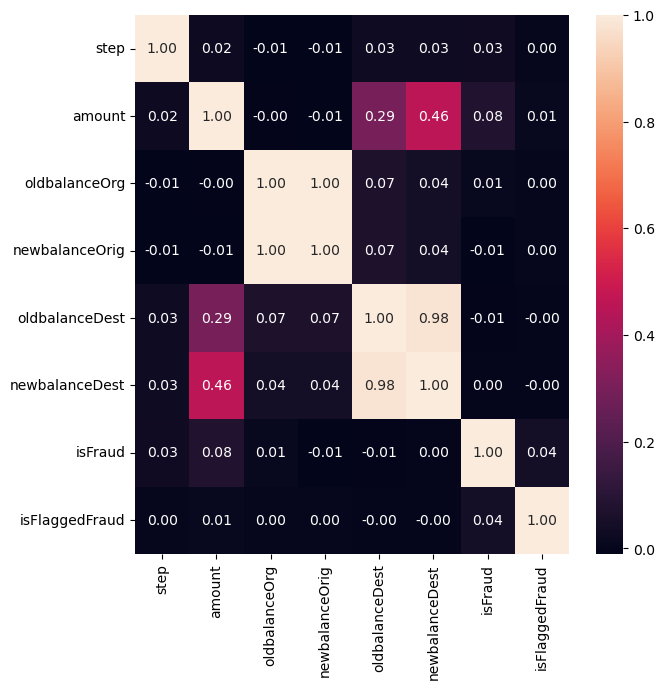

In [46]:
# plot the heat map to review correlation between features 
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

From the Heatmap above, we can easily see that the “newbalanceOrig” and the “oldbalanceOrg” have a very high correlation (0.98); hence we will only take one from the pair to create our model.

Here, we will take out the “oldbalanceOrg” just because New balance (NB) is cool.

In [47]:
# drop old balance 
df.drop(['oldbalanceOrg'], axis =1, inplace = True)

Asides from the inference above, we didn’t find out much from the heat map above, hence we should make use of another method to explore deeper into our dataset.

In [48]:
# Create a pivot table with fraud and isflagged fraud
df_pivot =pd.pivot_table(df,index=["type"],
                               values=['isFraud','isFlaggedFraud'],
                               aggfunc=[np.sum], margins=True)
# set option up to show values without exponential
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pprint(df_pivot)

                    sum        
         isFlaggedFraud isFraud
type                           
CASH_IN               0       0
CASH_OUT              0    4116
DEBIT                 0       0
PAYMENT               0       0
TRANSFER             16    4097
All                  16    8213


There’re a few inferences we can make from the pivot table above:

There’re only about 16 transactions that were flagged as fraud whereas around 4k transactions were actually fraud
For some reason, no cash out transaction was flagged as fraud, where as there were about 4116 fraudulent transactions in that transaction types
There’s probably an imbalance issue with the fact that there aren’t any fraudulent cash-in, debit and payment transactions, where as we’ve about 4116 in the cash out
We will need our model to be able to make a better prediction than what’s currently being made on the isFlaggedFraud column currently.

We could go on with the exploration, but I’ve decided to stop here for now in order not to make the article too long; please do let me know what exploratory processes you carried out in the comment section of this article.

## Handling Data Inbalance:
It’s important we create a model that is not partial to any specific label and to achieve this, we need to check for imbalance and if it exists, we need to handle it.

Below we use the Plotly library to create a piechart to see the distribution of the “isFraud” column of our dataset.

In [49]:

# checking for imbalance
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df['isFraud'].value_counts())])
fig.show()
plt.show(); 

From the pie-chart above, we can see that there are a lot more “Not Fraud” cases than “Fraud” cases; there’s an obvious imbalance, as we suspected earlier, in our class labels and if we don’t handle this, our model would classify most of the cases as non-fraudulent including a lot of actual fraud cases.

There’re many ways to handle an unbalanced dataset; one method is called resampling which is usually done after the dataset is split into training and test datasets, to avoid influencing the result of our models and to allow our test set to be independent of the training set. You can check this article https://towardsdatascience.com/how-to-deal-with-imbalanced-classification-without-re-balancing-the-data-8a3c02353fe3by David to learn more about handling unbalanced datasets.

Oversampling has two different sampling methods;

1. Under-sampling: Removing values from the majority dataset.
2. Over-sampling: In the simplest terms, this is adding more values to the minority dataset


For this article, we make use of the SMOTE over-sampling method, but as noted earlier, we need to do this only after we split our dataset, so we will get back to this once we split the dataset.

## Handling Categorical Values:

Our type feature is categorical and nominal by nature; I believe it’s a very important feature, hence as opposed to dropping it, we will use one-hot encoding to convert it from a categorical type to a numerical type.

Note: If it was ordinal by nature we would use an integer encoding method instead to convert it as opposed to one-hot encoding.

In [50]:
# convert categorical to numerical data with one-hot encoding
df = pd.concat([df,pd.get_dummies(df['type'], prefix='type_')],axis=1)
df.drop(['type', 'nameOrig', 'nameDest'],axis=1,inplace = True)

We achieved the one hot encoding by making use of Pandas get_dummies function as shown above. We dropped the type column as one-hot encoding would create a separate column for each of the values in the type column i.e. we would now have rows like type_CASH_IN, type_CASH_OUT, type_CASH_DEBIT and type_CASH_TRANSFER.

## Normalization:

It’s important we normalize our numerical data mainly because we do not want our model to be partial towards the higher values. Normalization converts our numerical values to a range between 0–1(or 2, or 10 or however large you want the maximum value) hence reducing the difference between the numerical columns and hence giving less precedence to the higher values.

The formula for normalization is: min value / (max value — min value) * new_max. In our case we want the value to be between 0 and 1 so we multiply by 1 as shown in the code snippet below:

In [51]:
# # Next we normalize our numerical features
# normalize our data manually by dividing the min/max and multiplying by the range 
# in this case we multiply by 1 as we want our data to be between 0 and 1
df=((df-df.min())/(df.max()-df.min()))*1
pprint(df)

         step  amount  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0       0.000   0.000           0.003           0.000           0.000   
1       0.000   0.000           0.000           0.000           0.000   
2       0.000   0.000           0.000           0.000           0.000   
3       0.000   0.000           0.000           0.000           0.000   
4       0.000   0.000           0.001           0.000           0.000   
...       ...     ...             ...             ...             ...   
6362615 1.000   0.004           0.000           0.000           0.001   
6362616 1.000   0.068           0.000           0.000           0.000   
6362617 1.000   0.068           0.000           0.000           0.018   
6362618 1.000   0.009           0.000           0.000           0.000   
6362619 1.000   0.009           0.000           0.018           0.021   

         isFraud  isFlaggedFraud  type__CASH_IN  type__CASH_OUT  type__DEBIT  \
0          0.000           0.000          0

## Training & Testing Split:

We have to split our dataset into training and testing in order to avoid the problem of overfitting i.e. our model only working very well for our current dataset. If we used the entire dataset to train our model, our accuracy would most likely be inaccurate, with every level of pun intended there

In [52]:

# splitting dependent and independent variable
X=df.drop('isFraud',axis=1)
y=df['isFraud']

# # Splitting our data into training and testing dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

We split the dataset into 30% testing data and 70% training data; you can split it however you want, but most times people split it either 70–30 or 80–20. Let me know what difference your split makes in the comment section.

## Continue Handling Data Imbalance:

As stated earlier, we make use of the SMOTE, which stands for Synthetic Minority Over-sampling Technique, which adds more value to our minority class. An implementation of SMOTE is defined in the imblearn library, it will be a good idea to check it out to find out other functions to use for handling data imbalance.

We implement the SMOTE function and apply its re-sampling method on our dataset as shown below:

In [53]:
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_resample(X_train, y_train)
pprint(X_train)

print(X_train.shape, y_train.shape)

#Checking the balanced target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=y_train.value_counts())])
fig.show()

         step  amount  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0       0.733   0.002           0.003           0.000           0.000   
1       0.334   0.000           0.000           0.000           0.000   
2       0.406   0.001           0.119           0.001           0.001   
3       0.482   0.003           0.000           0.009           0.009   
4       0.410   0.001           0.000           0.001           0.001   
...       ...     ...             ...             ...             ...   
8896173 0.061   0.006           0.000           0.000           0.000   
8896174 0.870   0.009           0.000           0.000           0.003   
8896175 0.310   0.028           0.000           0.000           0.000   
8896176 0.538   0.013           0.000           0.000           0.000   
8896177 0.017   0.016           0.000           0.000           0.000   

         isFlaggedFraud  type__CASH_IN  type__CASH_OUT  type__DEBIT  \
0                 0.000          1.000           0.0

As shown we now apply the SMOTE function only on our training dataset to avoid the balancing from influencing the accuracy of our dataset. We then draw a new pie chart to show our current distribution between the ‘Fraud’ and ‘Not Fraud’ values in our dataset. We get the pie chart below

Now we have an evenly distributed dataset to work with.

## Create our Models:

We’re finally here and for this phase, we will make use of 5 different classification algorithms: Multiperceptron Classifier, Decision Tree Classifier, K Nearest Neighbour Classifier, Support Vector Classifier and the Random Forest Classifier.

We achieve this with the code below.

In [ ]:
# Building model: 
mlp_cv = MLPClassifier()
rf_cv=RandomForestClassifier(random_state=123)
dt_cv=DecisionTreeClassifier(random_state=123)
svc_cv=SVC(kernel='linear',random_state=123)
knn_cv=KNeighborsClassifier()

# cv_dict = {0: 'Neural Network', 1: 'Random Forest',2:'Decision Tree',3:'SVC',4:'KNN'}
# cv_models=[mlp_cv,rf_cv, dt_cv, svc_cv, knn_cv]

cv_dict = {0: 'Random Forest Classifier'}
cv_models = [rf_cv]

for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X_train, y_train, cv=10, scoring ='accuracy').mean()))


The accuracy for our models is as follows:

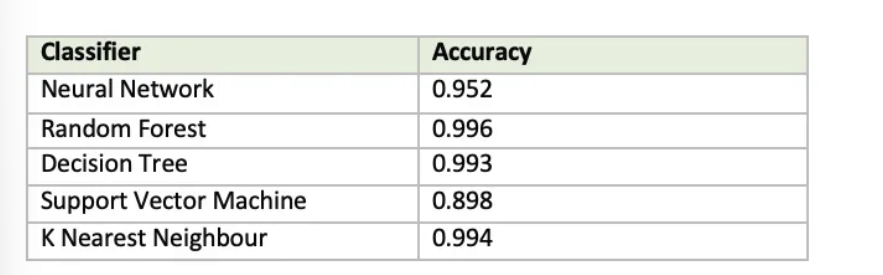

The not-so-obvious winner of our accuracy race has to go to the Random Forest classifier which was really not that far ahead of our Decision Tree classifier, but a win is a win.

I would have loved to fine-tune the hyperparameters for our classifiers but with such high accuracy, I don’t really feel it’s worth it, except maybe for the Neural network of course; if you do fine-tune its parameters, let me know in the comment section what you find out.

Model Evaluation

It’s now time to evaluate our models over our test data. There’re many ways to do this but we will stick with analyzing our precision, recall, f1-score and support score using the classification report function as shown below.

It’s important I give a brief description of what these mean.

Precision: Determines how trustworthy our model's prediction of a class is

Recall: Tells us how well our model can detect that a row belongs to a class

F1 Score: Harmonic mean of the precision and the recall

In [ ]:
rf_cv.fit(X_train, y_train)
#Predict with the selected best parameter
y_pred = rf_cv.predict(X_test)

# Model Evaluation 
print(classification_report(y_test, y_pred, target_names=['Not Fraud','Fraud']))

print(classification_report(y_test, y_pred, target_names=['Not Fraud','Fraud']))

The result is shown below:

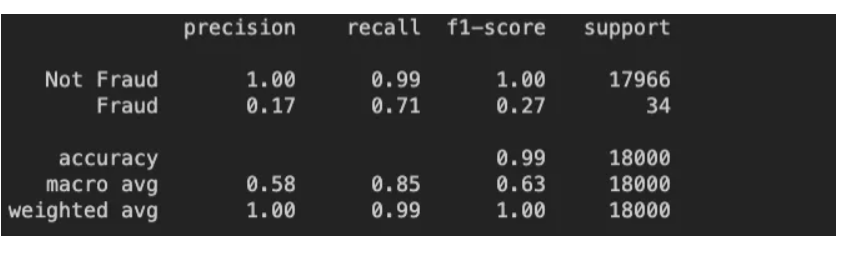


I’m normally optimistic, but this is too good to be true; our result is showing us that we have a precision of 1.00 and that means that our model is 100% trustworthy with the results that we get.

This is most unlikely but I will stick with it; I will test the model out with other datasets, just to see how good it performs and I hope you do the same and let me know what you think in the comment section.